In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn import base

from sklearn import ensemble, metrics

from actlearn.select import predict_posterior
from actlearn import utils

In [2]:
plt.rcParams.update({"font.size":14})

In [3]:
from rdkit.Chem.Draw import IPythonConsole

In [4]:
def score_regression(y_val, y_pred):
    performance = {}
    performance["r2"] = metrics.r2_score(y_val, y_pred)
    performance["mae"] = metrics.mean_absolute_error(y_val, y_pred)
    performance["rmse"] = metrics.mean_squared_error(y_val, y_pred, squared=False)
    performance["spearmanr"] = scipy.stats.spearmanr(y_val, y_pred)
    return performance

def score_classification(y_val, y_pred):
    performance = {}
    performance["accuracy"] = metrics.accuracy_score(y_val, y_pred)
    performance["f1_score"] = metrics.f1_score(y_val, y_pred)
    return performance


def scale_train_predict(df, df_test, features, target, model):
    scaler = StandardScaler()
    scaler.fit(df[features])
    X_train = scaler.transform(df[features])
    X_test = scaler.transform(df_test[features])

    model = base.clone(model)
    model.fit(X_train, df[target])
    #y_pred = model.predict(X_test)
    y_pred, y_std = predict_posterior(model, X_test)
    print(score_regression(df_test[target], y_pred))
    return y_pred, y_std


def compare_datasets(df1, df2, df_test, features, target, model):
    scale_train_predict(df1, df_test, features, target, model)
    scale_train_predict(df2, df_test, features, target, model)

In [5]:
task_name = "CAD Yield (%)"

In [6]:
from rdkit.Chem.MolStandardize import rdMolStandardize

params = rdMolStandardize.CleanupParameters()
params.maxTautomers = 100
params.maxTransforms = 100
te = rdMolStandardize.TautomerEnumerator(params)

def rxn_dfp(rsmi):
    r, _, p = rsmi.split('>')
    rfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(r), 4, useChirality=True)
    pfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(p), 4, useChirality=True)
    return np.array(pfp) - np.array(rfp)

In [7]:
domain = pd.read_csv("../data/brbr_reaction_domain_batch5.csv")
df_exp = pd.read_csv("../data/experimental_results_batch5.csv")

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# add features to domain
domain_dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(utils.rxn_dfp)(rsmi) for rsmi in domain['rsmi']
))
# merging alkyl and aryl DFT features with reaction fingerprints
f_cols = [f'f_{idx}' for idx in range(2048)]
# adding features to domain
domain.loc[:, f_cols] = domain_dfp

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   15.0s
[Parallel(n_jobs=32)]: Done 1600 tasks      | elapsed:   15.4s
[Parallel(n_jobs=32)]: Done 12320 tasks      | elapsed:   17.3s
[Parallel(n_jobs=32)]: Done 26720 tasks      | elapsed:   19.6s
[Parallel(n_jobs=32)]: Done 33160 tasks      | elapsed:   21.2s
[Parallel(n_jobs=32)]: Done 33312 out of 33312 | elapsed:   21.3s finished


KeyboardInterrupt: 

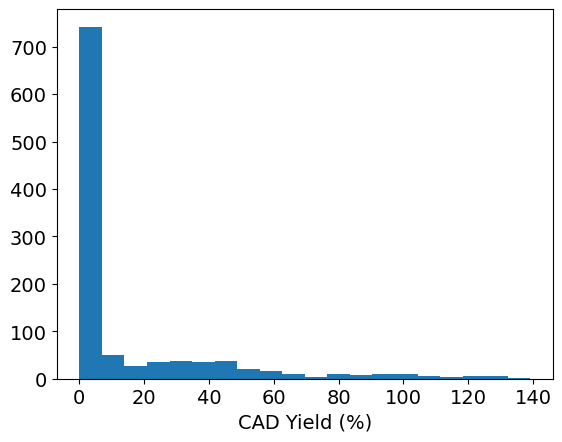

In [18]:
plt.hist(df_exp["CAD Yield (%)"], bins=20)
plt.xlabel("CAD Yield (%)")
plt.show()

In [19]:
print(len(domain["CAD Yield (%)"].dropna()))
print(len(df_exp["CAD Yield (%)"].dropna()))

1074
1074


In [20]:
# full domain has 33312 products from 2776 alkyl bromides and 12 aryl bromides
domain.shape

(33312, 2147)

In [21]:
dom_untested = domain[domain["CAD Yield (%)"].isna()]

In [22]:
df_exp["selection"].value_counts()

selection
active_learning_2           96
random_1                    95
random_3                    93
test_2                      91
random_4                    90
active_learning_3           86
random_2                    84
initial_diverse             83
active_learning_1           76
test_1                      70
cores2_test_1               45
cores2_active_learning_1    45
cores2_active_learning_2    44
cores2_test_2               44
test_3                      32
Name: count, dtype: int64

In [23]:
# for the next batch, we want to make selections that have a large difference between model predictions from models trained on the random and AL datasets
# for fairness, diverse+AL has 4 batches, and random has 4 batches on the initial 8 cores. Shouldn't use data for the new cores, even though we are going to make selections for them
al_train = ["initial_diverse", "active_learning_1", "active_learning_2", "active_learning_3"]
rand_train = ["random_1", "random_2", "random_3", "random_4"]
df_al = df_exp[df_exp["selection"].isin(al_train)]
df_rand = df_exp[df_exp["selection"].isin(rand_train)]
print(df_al.shape, df_rand.shape)

(341, 2147) (362, 2147)


In [24]:
f_cols = [c for c in df_exp.columns if c.startswith("f_")]
target = "CAD Yield (%)"
print(len(f_cols))

2135


In [25]:
# split domain into old and new cores
og_cores = df_al["smiles_aryl"].unique()
dom_og = domain[domain["smiles_aryl"].isin(og_cores)]
dom_new = domain[~domain["smiles_aryl"].isin(og_cores)]
print(dom_og.shape, dom_new.shape)

(22208, 2147) (11104, 2147)


In [26]:
model_al = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=42)
model_al.fit(df_al[f_cols], df_al[target])
model_rand = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=42)
model_rand.fit(df_rand[f_cols], df_rand[target])

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [27]:
df_rand["CAD Yield (%)"].describe()

count    362.000000
mean       5.541863
std       14.163510
min        0.000000
25%        0.000000
50%        0.000000
75%        2.497932
max       96.515211
Name: CAD Yield (%), dtype: float64

In [28]:
df_al["CAD Yield (%)"].describe()

count    341.000000
mean      21.302105
std       29.500088
min        0.000000
25%        0.000000
50%        3.186929
75%       36.455220
max      125.940938
Name: CAD Yield (%), dtype: float64

In [29]:
al_pred_og = model_al.predict(dom_og[f_cols])
al_pred_new = model_al.predict(dom_new[f_cols])
rand_pred_og = model_rand.predict(dom_og[f_cols])
rand_pred_new = model_rand.predict(dom_new[f_cols])

In [30]:
score_regression(al_pred_og, rand_pred_og)

{'r2': 0.09200814707768346,
 'mae': 8.726193492809347,
 'rmse': 14.686820738997545,
 'spearmanr': SpearmanrResult(correlation=0.6220410935970437, pvalue=0.0)}

In [31]:
score_regression(al_pred_new, rand_pred_new)

{'r2': 0.003387692392339714,
 'mae': 9.102462074859902,
 'rmse': 14.5063432355796,
 'spearmanr': SpearmanrResult(correlation=0.5804333920665063, pvalue=0.0)}

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


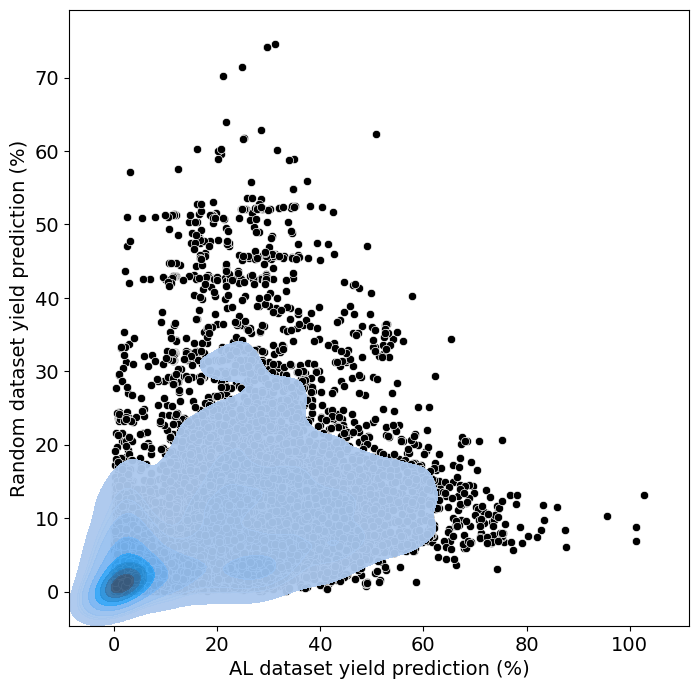

In [32]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=al_pred_og, y=rand_pred_og, c="k")
sns.kdeplot(x=al_pred_og, y=rand_pred_og, alpha=0.95, fill=True)
plt.xlabel("AL dataset yield prediction (%)")
plt.ylabel("Random dataset yield prediction (%)")
plt.show()

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


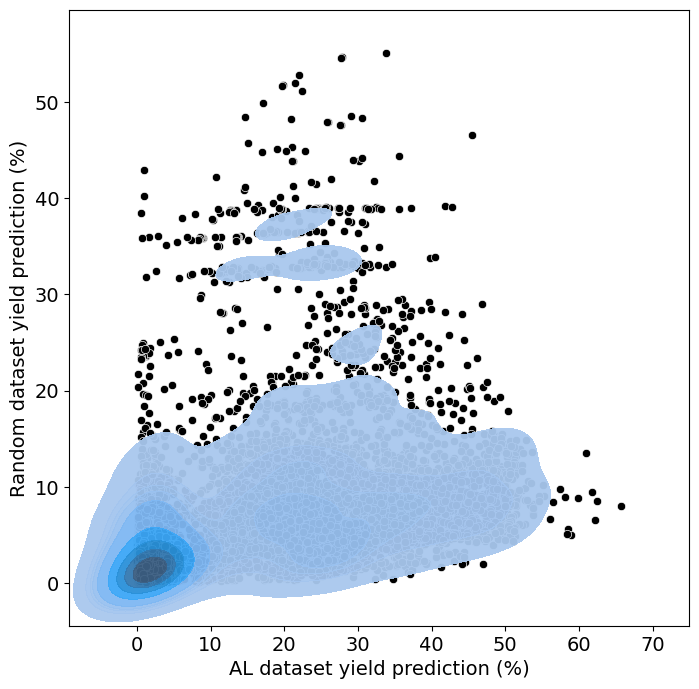

In [33]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=al_pred_new, y=rand_pred_new, c="k")
sns.kdeplot(x=al_pred_new, y=rand_pred_new, alpha=0.95, fill=True)
plt.xlabel("AL dataset yield prediction (%)")
plt.ylabel("Random dataset yield prediction (%)")
plt.show()

In [34]:
dom_new["yield_al_pred"] = al_pred_new
dom_new["yield_rand_pred"] = rand_pred_new

/tmp/ipykernel_65347/2501376026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dom_new["yield_al_pred"] = al_pred_new
/tmp/ipykernel_65347/2501376026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dom_new["yield_rand_pred"] = rand_pred_new


In [35]:
dom_new["yield_pred_diff"] = al_pred_new - rand_pred_new
dom_new.sort_values(by="yield_pred_diff", inplace=True)
head10 = dom_new.head(10)
tail10 = dom_new.tail(10)

/tmp/ipykernel_65347/1682521076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dom_new["yield_pred_diff"] = al_pred_new - rand_pred_new
/tmp/ipykernel_65347/1682521076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dom_new.sort_values(by="yield_pred_diff", inplace=True)


In [36]:
head10[["yield_al_pred", "yield_rand_pred"]]

,yield_al_pred,yield_rand_pred
30620,0.882357,42.896196
27844,0.911526,40.181846
30557,0.571869,38.433895
27781,0.643606,35.831552
22292,1.563248,35.916470
28938,14.679252,48.405061
25068,2.881159,36.095030
28169,17.109072,49.829779
28279,19.722729,51.678472
28170,19.802405,51.722425


In [37]:
tail10[["yield_al_pred", "yield_rand_pred"]]

,yield_al_pred,yield_rand_pred
22881,58.121071,8.971390
25657,56.032370,6.635440
25062,59.853290,8.893388
23756,61.718280,9.489134
28665,58.549079,5.629747
32084,58.322121,5.092591
23113,62.418426,8.512953
31441,58.880314,4.966711
25889,62.115436,6.553751
26532,65.706528,8.011105


In [38]:
dom_new.to_csv("iterations/batch5_core2_domain_predictions.csv", index=False)

In [39]:
dom_new_alk = dom_new.groupby("smiles_alkyl")[["yield_al_pred", "yield_rand_pred"]+f_cols].mean()
dom_new_alk.head(3)

,yield_al_pred,yield_rand_pred,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_Br_tm_water_nucleophilic_paboon,f_Br_tm_water_nucleophilic_fasm,f_Br_tm_water_electrophilic_mulliken,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm
smiles_alkyl,,,,,,,,,,,,,,,,,,,,,
BrC(c1ccccc1)(c1ccccc1)c1ccccc1,3.068583,4.562425,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.2409,0.2251,0.1816,0.1743,0.1811,0.1545,0.2246,0.2087,0.2110,0.1898
BrC(c1ccccc1)c1ccccc1,0.928681,1.969390,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.2134,0.2427,0.2008,0.1925,0.1961,0.1918,0.2281,0.2148,0.2047,0.2172
BrC(c1ccccc1)c1ccccn1,1.147306,6.582984,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.2037,0.2310,0.1698,0.1575,0.1596,0.1661,0.2055,0.1909,0.1816,0.1986


In [40]:
dom_new.shape

(11104, 2150)

In [41]:
dom_new_alk["yield_pred_diff"] = dom_new_alk["yield_al_pred"] - dom_new_alk["yield_rand_pred"]
dom_new_alk.sort_values(by="yield_pred_diff", inplace=True)
alk_head10 = dom_new_alk.head(10)
alk_tail10 = dom_new_alk.tail(10)
alk_head10

,yield_al_pred,yield_rand_pred,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_Br_tm_water_nucleophilic_fasm,f_Br_tm_water_electrophilic_mulliken,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm,yield_pred_diff
smiles_alkyl,,,,,,,,,,,,,,,,,,,,,
O=C1c2ccccc2C(=O)N1CCCCCCCCBr,1.559572,38.772385,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.0217,0.2121,0.2178,0.2231,0.1943,0.1042,0.1077,0.1105,0.1080,-37.212813
O=C1c2ccccc2C(=O)N1CCCCCCCCCCBr,1.223318,34.621672,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.0004,0.1961,0.1970,0.2030,0.1795,0.0982,0.0986,0.1021,0.0900,-33.398353
CCCCCCCCCBr,5.772378,34.208434,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.4496,0.4098,0.4101,0.4218,0.3752,0.4254,0.4117,0.3828,0.4124,-28.436056
CCOCCCCCCCCCBr,19.097007,47.372064,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.4022,0.1991,0.1974,0.2044,0.1877,0.3007,0.2864,0.2579,0.2950,-28.275057
COC(=O)CCCCCCCCCCCBr,20.725506,48.186154,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.3030,0.2911,0.2882,0.2993,0.2670,0.2929,0.2846,0.2573,0.2850,-27.460648
CCCCCCCCCCCCBr,7.399340,34.546391,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.4479,0.3417,0.3421,0.3518,0.3131,0.3907,0.3769,0.3464,0.3805,-27.147050
BrCCCCCCCCCC1OCCO1,14.747422,41.457801,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.4084,0.1893,0.1892,0.1955,0.1758,0.2972,0.2850,0.2560,0.2921,-26.710379
OCCCCCCCCCBr,9.794314,35.041139,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.4498,0.2519,0.2527,0.2607,0.2306,0.3466,0.3331,0.3024,0.3402,-25.246825
COC(=O)CCCCCCCCCCBr,25.209357,50.425815,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.2942,0.3050,0.3060,0.3174,0.2688,0.3001,0.2943,0.2697,0.2815,-25.216457


In [42]:
dom_new_alk.reset_index(inplace=True)
dom_new_alk["mol"] = dom_new_alk["smiles_alkyl"].apply(Chem.MolFromSmiles)

In [43]:
print(dom_new_alk.shape)
dom_new_alk = dom_new_alk[~dom_new_alk["smiles_alkyl"].isin(df_exp["smiles_alkyl"])]
print(dom_new_alk.shape)

(2776, 2140)
(2643, 2140)


In [44]:
dom_cross_al = dom_new_alk[(dom_new_alk["yield_rand_pred"] <= 10) & (dom_new_alk["yield_al_pred"] >= 40)]
dom_cross_rand = dom_new_alk[(dom_new_alk["yield_rand_pred"] >= 15) & (dom_new_alk["yield_al_pred"] <= 10)]
print(dom_cross_al.shape, dom_cross_rand.shape)

(115, 2140) (12, 2140)


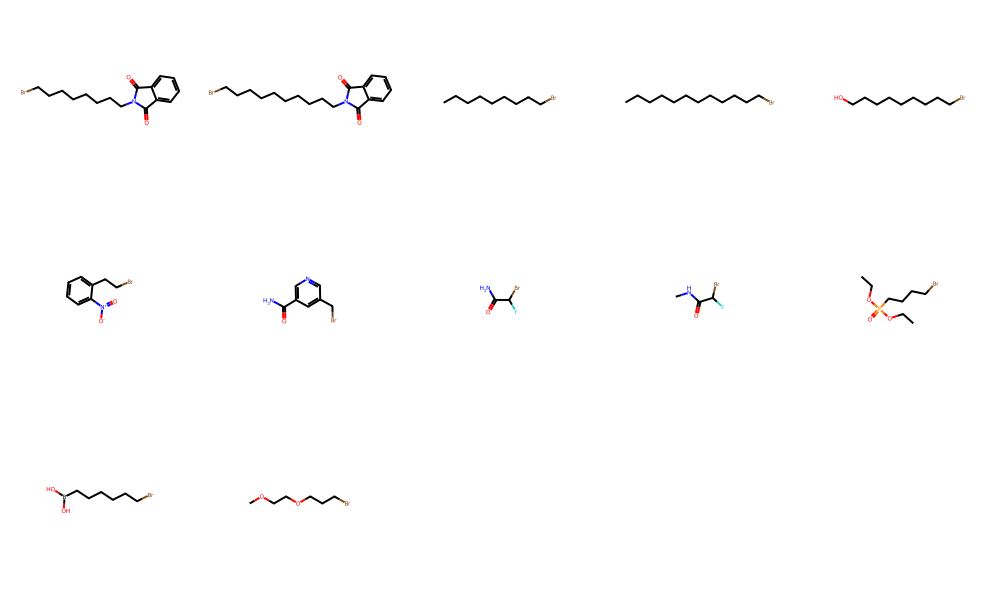

In [45]:
Chem.Draw.MolsToGridImage(dom_cross_rand["mol"], molsPerRow=5)

In [46]:
dom_cross_al[f_cols]

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_Br_tm_water_nucleophilic_paboon,f_Br_tm_water_nucleophilic_fasm,f_Br_tm_water_electrophilic_mulliken,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm
2597,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,0.00,0.0,0.0,...,0.1176,0.1810,0.0978,0.0960,0.0983,0.0963,0.1372,0.1341,0.1080,0.1387
2603,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0412,0.0837,0.0754,0.0749,0.0760,0.0814,0.0744,0.0739,0.0586,0.0825
2606,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0444,0.0903,0.0925,0.0931,0.0944,0.0993,0.0853,0.0853,0.0694,0.0948
2607,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,0.00,0.0,0.0,...,0.1142,0.1968,0.0741,0.0695,0.0696,0.0902,0.1267,0.1158,0.0919,0.1435
2613,0.0,0.0,0.0,-0.25,0.0,0.0,0.25,0.25,0.0,0.0,...,0.1009,0.1397,0.1322,0.1260,0.1277,0.1322,0.1378,0.1318,0.1143,0.1360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0116,0.0289,0.0806,0.0769,0.0777,0.0893,0.0487,0.0456,0.0447,0.0591
2769,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0112,0.0170,0.0959,0.0914,0.0924,0.0959,0.0549,0.0514,0.0518,0.0564
2770,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0574,0.0876,0.0401,0.0338,0.0330,0.0463,0.0606,0.0555,0.0452,0.0669
2771,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0400,0.0780,0.0187,0.0163,0.0160,0.0281,0.0415,0.0389,0.0280,0.0531


In [47]:
print(dom_cross_al.shape, dom_cross_rand.shape)

(115, 2140) (12, 2140)


In [48]:
dom_cross_al.to_csv("iterations/batch5_AL_picks.csv", index=False)
dom_cross_rand.to_csv("iterations/batch5_rand_picks.csv", index=False)

In [49]:
from sklearn.cluster import KMeans

In [44]:
#df_al = files.sdf2df("/home/rickena1/modules/mcds-actlearn/notebooks/iterations/batch6_AL_cluster_picks.sdf")

In [50]:
dft_cols = f_cols[2048:]
dom_cross_al_std = dom_cross_al.copy()
scaler = StandardScaler()
scaler.fit(dom_cross_al[dft_cols])
dom_cross_al_std[dft_cols] = scaler.transform(dom_cross_al[dft_cols])

In [51]:
dom_cross_al_std

,smiles_alkyl,yield_al_pred,yield_rand_pred,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_Br_tm_water_electrophilic_mulliken,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm,yield_pred_diff,mol
2597,Cc1cccc(C)c1OCCCBr,41.992505,9.604541,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.725585,0.792174,0.807024,0.544080,0.744282,0.798949,0.689311,0.609420,32.387963,<rdkit.Chem.rdchem.Mol object at 0x7fc216cf6ce0>
2603,FC(F)(F)c1cccc(OCCCCBr)c1,42.622858,9.892167,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.183799,0.277388,0.279492,0.152398,-0.529101,-0.457354,-0.476887,-0.551714,32.730691,<rdkit.Chem.rdchem.Mol object at 0x7fc216cf6a40>
2606,FC(F)(F)c1ccccc1OCCCCBr,42.698158,9.834027,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.597395,0.721421,0.714765,0.622942,-0.308084,-0.219449,-0.221929,-0.297587,32.864132,<rdkit.Chem.rdchem.Mol object at 0x7fc216cf68f0>
2607,Oc1cccc(CCBr)c1,40.974016,8.062743,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.152356,0.145642,0.128093,0.383727,0.531376,0.417050,0.309234,0.708592,32.911273,<rdkit.Chem.rdchem.Mol object at 0x7fc216cf6880>
2613,O=C(OCc1ccccc1)N1CCC(Br)CC1,41.728337,8.583735,0.0,0.0,0.0,-0.25,0.0,0.0,0.25,...,1.557613,1.524097,1.502515,1.487796,0.756448,0.750951,0.838036,0.553636,33.144601,<rdkit.Chem.rdchem.Mol object at 0x7fc216cf65e0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,CC(=O)c1ccccc1OCCBr,49.563814,6.073930,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.309571,0.326183,0.319708,0.360068,-1.050215,-1.047941,-0.805027,-1.035175,43.489884,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59cb0>
2769,N#Cc1ccccc1OCCBr,49.976551,6.279831,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.679630,0.679946,0.667453,0.533565,-0.924499,-0.926902,-0.637416,-1.090959,43.696719,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59c40>
2770,COc1ccc(C2=NCC(CBr)S2)cc1,53.244393,8.101725,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,-0.669997,-0.725346,-0.737722,-0.770288,-0.808921,-0.841340,-0.793224,-0.874021,45.142668,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59bd0>
2771,O=S(=O)(c1ccc(OCCBr)cc1)N1CCOCC1,52.101397,6.647385,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,-1.187596,-1.152301,-1.139877,-1.248718,-1.196208,-1.187762,-1.199268,-1.159140,45.454012,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59b60>


In [52]:
dom_cross_al_std[dft_cols].std()

f_core_tm_water_ionization_potential [eV]    0.000000
f_core_tm_water_electron_affinity [eV]       0.000000
f_core_tm_water_hardness [eV]                0.000000
f_core_tm_water_electronegativity [eV]       0.000000
f_core_tm_water_electrophilicity [eV]        0.000000
                                               ...   
f_Br_tm_water_electrophilic_fasm             1.004376
f_Br_tm_water_radical_mulliken               1.004376
f_Br_tm_water_radical_loewdin                1.004376
f_Br_tm_water_radical_paboon                 1.004376
f_Br_tm_water_radical_fasm                   1.004376
Length: 87, dtype: float64

In [53]:
estimator = KMeans(n_clusters=24)
estimator.fit(dom_cross_al_std[f_cols])
dom_cross_al_std["cluster"] = estimator.labels_
dom_cluster_al = dom_cross_al_std.sort_values(by="yield_pred_diff", ascending=False).drop_duplicates(subset="cluster")
dom_cluster_picks_std = dom_cluster_al[~dom_cluster_al["smiles_alkyl"].isin(df_al["smiles"])]
dom_cluster_picks_std.shape

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(24, 2141)

In [54]:
estimator = KMeans(n_clusters=24)
estimator.fit(dom_cross_al[f_cols])
dom_cross_al["cluster"] = estimator.labels_
dom_cluster_al = dom_cross_al.sort_values(by="yield_pred_diff", ascending=False).drop_duplicates(subset="cluster")
dom_cluster_picks = dom_cluster_al[~dom_cluster_al["smiles_alkyl"].isin(df_al["smiles"])]
dom_cluster_picks.shape

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_65347/3831585385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dom_cross_al["cluster"] = estimator.labels_


(24, 2141)

In [55]:
dom_cluster_picks

,smiles_alkyl,yield_al_pred,yield_rand_pred,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm,yield_pred_diff,mol,cluster
2773,BrCCOc1ccccc1-n1cnnc1,54.250823,6.698877,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0362,0.0361,0.0442,0.0585,0.0549,0.0421,0.0624,47.551946,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59a80>,19
2771,O=S(=O)(c1ccc(OCCBr)cc1)N1CCOCC1,52.101397,6.647385,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.0163,0.0160,0.0281,0.0415,0.0389,0.0280,0.0531,45.454012,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59b60>,17
2770,COc1ccc(C2=NCC(CBr)S2)cc1,53.244393,8.101725,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.0338,0.0330,0.0463,0.0606,0.0555,0.0452,0.0669,45.142668,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59bd0>,6
2768,CC(=O)c1ccccc1OCCBr,49.563814,6.073930,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0769,0.0777,0.0893,0.0487,0.0456,0.0447,0.0591,43.489884,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59cb0>,8
2767,N#Cc1cccc(OCCCBr)c1,49.250637,5.904697,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.1079,0.1093,0.1125,0.0576,0.0562,0.0564,0.0620,43.345940,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59d20>,21
2766,O=C1Nc2ccccc2SC1CCBr,49.949905,7.156022,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.0230,0.0218,0.0428,0.0310,0.0265,0.0221,0.0458,42.793884,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59d90>,15
2764,BrCCc1ccc2ccccc2c1,49.353369,6.758264,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.0342,0.0332,0.0597,0.0330,0.0285,0.0247,0.0546,42.595105,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59e70>,9
2763,Cn1c(=O)c2c(ncn2CCCBr)n(C)c1=O,49.409178,6.993010,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.0481,0.0506,0.0505,0.0559,0.0519,0.0486,0.0569,42.416167,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59ee0>,16
2761,Clc1ccc(C2(Cn3cncn3)CC(Br)CO2)c(Cl)c1,49.571190,7.608489,0.0,0.0,0.0,-0.25,0.0,0.0,0.00,...,0.0950,0.1001,0.0954,0.1042,0.0972,0.0893,0.1024,41.962702,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59fc0>,12
2757,BrCCOc1cccc2c1OCCO2,48.869288,7.080969,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0165,0.0152,0.0267,0.1199,0.1166,0.0908,0.1308,41.788318,<rdkit.Chem.rdchem.Mol object at 0x7fc216c5a180>,23


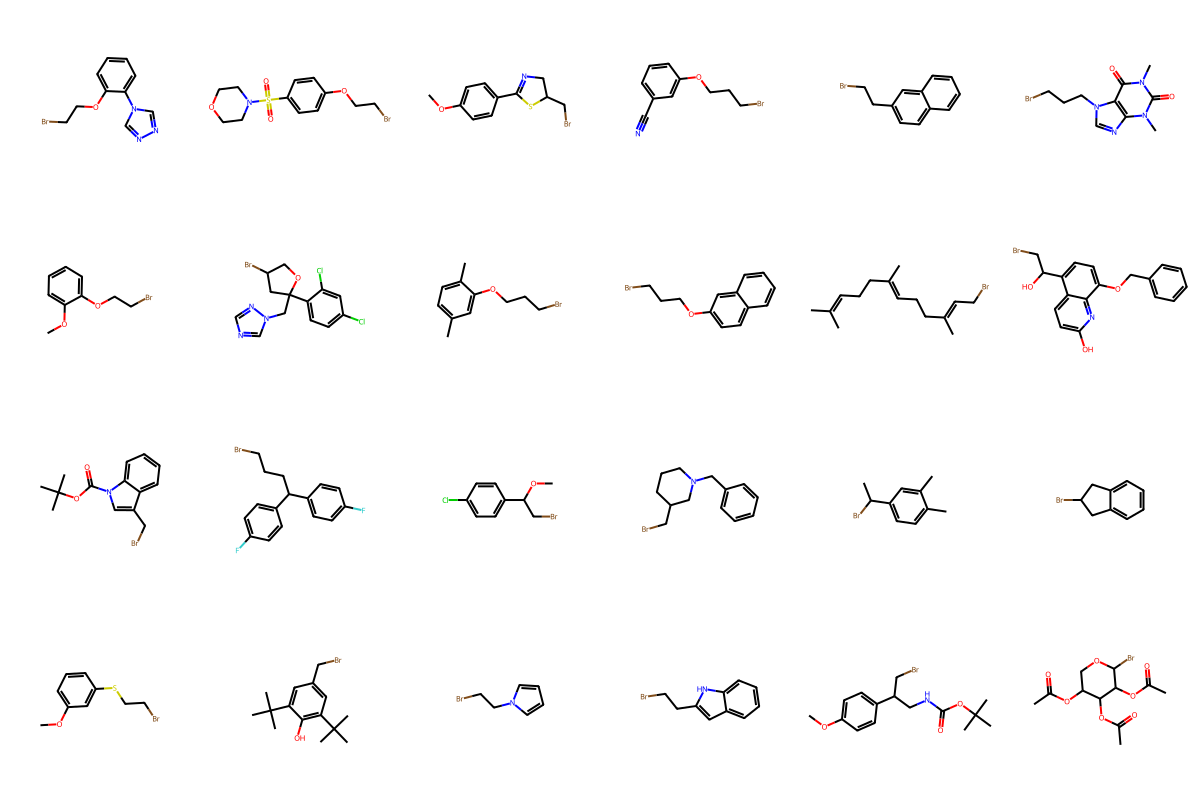

In [57]:
Chem.Draw.MolsToGridImage(dom_cluster_picks_std["mol"], molsPerRow=6)

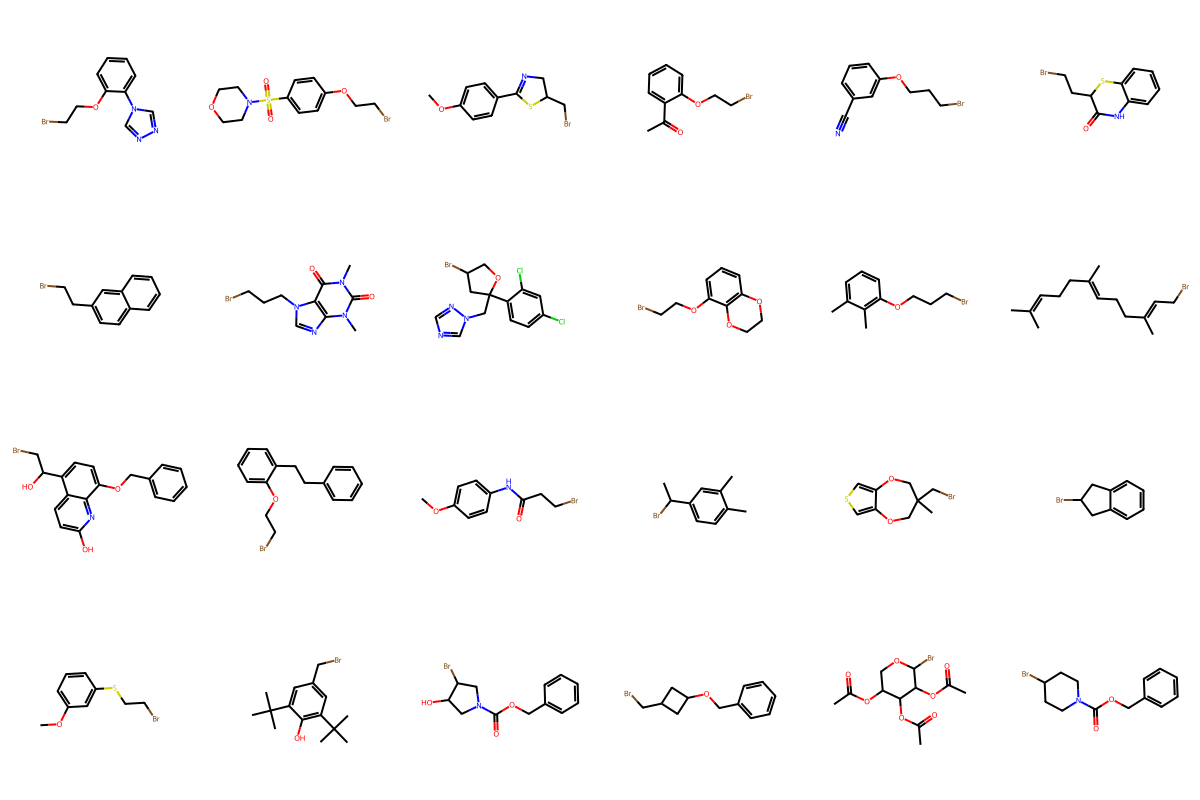

In [58]:
Chem.Draw.MolsToGridImage(dom_cluster_al["mol"], molsPerRow=6)

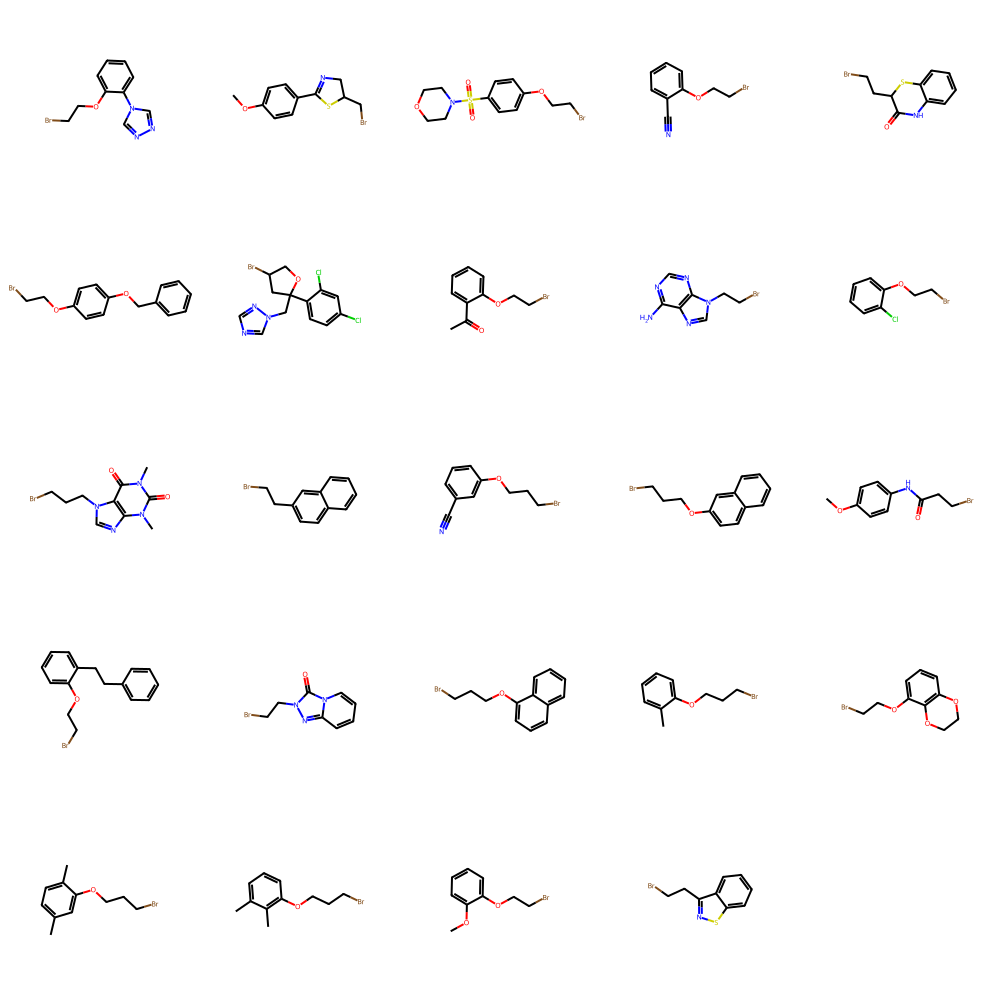

In [59]:
Chem.Draw.MolsToGridImage(dom_cross_al.sort_values(by="yield_al_pred", ascending=False)["mol"].head(24), molsPerRow=5)

In [60]:
al_picks = dom_cross_al.sort_values(by="yield_al_pred", ascending=False).head(24)
rand_picks = dom_cross_rand
print(al_picks.shape, rand_picks.shape)

(24, 2141) (12, 2140)


In [61]:
al_picks

,smiles_alkyl,yield_al_pred,yield_rand_pred,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm,yield_pred_diff,mol,cluster
2773,BrCCOc1ccccc1-n1cnnc1,54.250823,6.698877,0.0,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0362,0.0361,0.0442,0.0585,0.0549,0.0421,0.0624,47.551946,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59a80>,19
2770,COc1ccc(C2=NCC(CBr)S2)cc1,53.244393,8.101725,0.0,0.0,0.0,-0.25,0.00,0.0,0.0,...,0.0338,0.0330,0.0463,0.0606,0.0555,0.0452,0.0669,45.142668,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59bd0>,6
2771,O=S(=O)(c1ccc(OCCBr)cc1)N1CCOCC1,52.101397,6.647385,0.0,0.0,0.0,-0.25,0.00,0.0,0.0,...,0.0163,0.0160,0.0281,0.0415,0.0389,0.0280,0.0531,45.454012,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59b60>,17
2769,N#Cc1ccccc1OCCBr,49.976551,6.279831,0.0,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0914,0.0924,0.0959,0.0549,0.0514,0.0518,0.0564,43.696719,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59c40>,19
2766,O=C1Nc2ccccc2SC1CCBr,49.949905,7.156022,0.0,0.0,0.0,-0.25,0.00,0.0,0.0,...,0.0230,0.0218,0.0428,0.0310,0.0265,0.0221,0.0458,42.793884,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59d90>,15
2765,BrCCOc1ccc(OCc2ccccc2)cc1,49.944039,7.282267,0.0,0.0,0.0,-0.25,0.00,0.0,0.0,...,0.0243,0.0233,0.0481,0.0528,0.0495,0.0350,0.0659,42.661772,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59e00>,17
2761,Clc1ccc(C2(Cn3cncn3)CC(Br)CO2)c(Cl)c1,49.571190,7.608489,0.0,0.0,0.0,-0.25,0.00,0.0,0.0,...,0.0950,0.1001,0.0954,0.1042,0.0972,0.0893,0.1024,41.962702,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59fc0>,12
2768,CC(=O)c1ccccc1OCCBr,49.563814,6.073930,0.0,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0769,0.0777,0.0893,0.0487,0.0456,0.0447,0.0591,43.489884,<rdkit.Chem.rdchem.Mol object at 0x7fc216c59cb0>,8
2733,Nc1ncnc2c1ncn2CCBr,49.554328,9.134085,0.0,0.0,0.0,-0.25,0.00,0.0,0.0,...,0.0322,0.0320,0.0500,0.0660,0.0617,0.0433,0.0827,40.420242,<rdkit.Chem.rdchem.Mol object at 0x7fc216c5ad50>,9
2726,Clc1ccccc1OCCBr,49.534859,9.696364,0.0,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0454,0.0450,0.0545,0.1034,0.0991,0.0775,0.1089,39.838496,<rdkit.Chem.rdchem.Mol object at 0x7fc216c5b060>,19


In [63]:
def write_sdf(df, outfile, smiles_col):
    with Chem.SDWriter(outfile) as w:
        for smi in df[smiles_col].unique():
            w.write(Chem.MolFromSmiles(smi))

In [64]:
write_sdf(dom_cluster_picks_std, "iterations/batch5_AL_cross_picks_supplement.sdf", "smiles_alkyl")

In [65]:
print(dom_cluster_picks_std["smiles_alkyl"].isin(df_exp["smiles_alkyl"]).value_counts())
print(dom_cluster_picks_std["smiles_alkyl"].isin(df_al["smiles"]).value_counts())

smiles_alkyl
False    24
Name: count, dtype: int64
smiles_alkyl
False    24
Name: count, dtype: int64


In [66]:
write_sdf(al_picks, "iterations/batch5_AL_cross_picks.sdf", "smiles_alkyl")
write_sdf(rand_picks, "iterations/batch5_rand_cross_picks.sdf", "smiles_alkyl")

In [67]:
write_sdf(dom_cluster_al, "iterations/batch5_AL_cluster_picks.sdf", "smiles_alkyl")